## 3) Inestabilidades en flujos estratificados

> Haciendo uso del solver BOUSS en GHOST,
resuelva numéricamente las ecuaciones para un flujo incompresible con $ρ_0=1$,
en un recinto cubico de longitud $4π × 2π × 2π$
y resolución espacial $N_x=256$, $N_y=16$, $N_z=128$.
Hacer uso del Material Adicional.
Utilice como condición inicial el siguiente perfil para la velocidad horizontal
> $$ \frac{u}{u_0} = \tanh[γ(z − π/2)] + \tanh[γ(−z + 3π/2)] − 1 \tag{6} $$
> donde $γ$ controla la pendiente de la tangente hiperbólica,
y por lo tanto el gradiente de la velocidad inicial.
A la vez, perturbe este perfil con un campo de velocidad aleatorio con amplitud $u_1$.

In [1]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import sympy
import xarray
from ghost_xarray import open_dataarray, open_dataset

plt.rc("figure", dpi=100, figsize=(6, 3))
path = Path("problema3/output")

### a)
> Grafique el perfil de la velocidad $u(z)$,
y calcule analíticamente el máximo número de Richardson en
función de la frecuencia de Brunt-Väisälä $N$ y de $γ$.

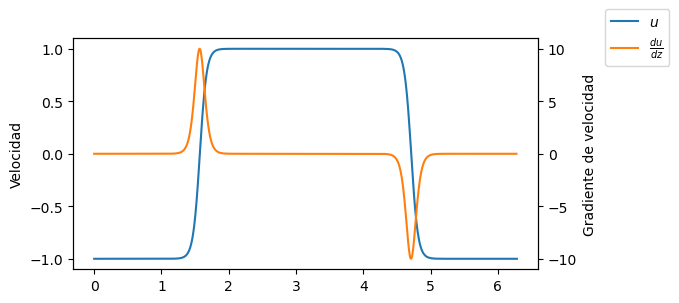

In [2]:
def initial_u(z, gamma):
    return np.tanh(gamma * (z - np.pi / 2)) + np.tanh(gamma * (-z + 3 * np.pi / 2)) - 1

z = np.linspace(0, 2 * np.pi, 2**10)
u = initial_u(z, 10)
dudz = np.diff(u) / np.diff(z)


fig, ax = plt.subplots()

ax.set(ylabel="Velocidad")
ax.plot(z, u, label="$u$")

ax2 = ax.twinx()
ax2.set(ylabel="Gradiente de velocidad")
ax2.plot(z[:-1], dudz, color="C1", label="$\\frac{du}{dz}$")

fig.legend(loc="upper left", bbox_to_anchor=(1, 1))

El número de Richardson, $R_i$, es:

$$ R_i = \frac{g}{ρ} \frac{∂ρ/∂z}{(∂u/∂z)^2} = \frac{N^2}{(∂u/∂z)^2} $$

donde
$g$ es la gravedad,
$ρ$ es la densidad,
$u$ es la velocidad,
$z$ es la profundidad, y
$N$ es el número de Brunt-Väisälä.

In [3]:
gamma, z = sympy.symbols("gamma z")
perfil_u = sympy.tanh(gamma * (z - sympy.pi / 2)) + sympy.tanh(gamma * (-z + 3 * sympy.pi / 2)) - 1

sympy.simplify(perfil_u)

-tanh(gamma*(2*z - 3*pi)/2) + tanh(gamma*(2*z - pi)/2) - 1

Derivando y evaluando el punto medio del gradiente de velocidad, $z = \pi / 2$:

In [4]:
sympy.simplify(sympy.diff(perfil_u, z).subs(z, sympy.pi / 2))

gamma*tanh(pi*gamma)**2

Entonces,
el valor para el numero de Richardson es:

$$ R_i(N, \gamma) = \frac{N^2}{\gamma^2 \tanh^4(\pi \gamma)} $$

que podríamos aproximar por

$$ R_i(N, \gamma) = \frac{N^2}{\gamma^2} $$

para $\gamma > 1$.

[Text(0.5, 0, '$\\gamma$'), Text(0.5, 1.0, '$N = 2$'), None, None]

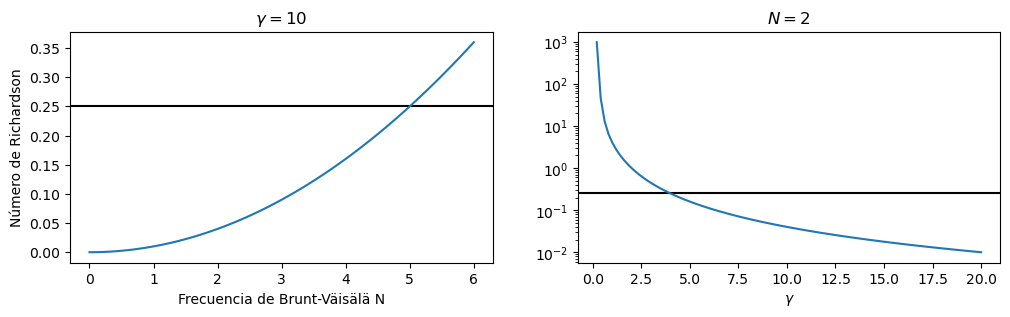

In [5]:
def richardson(N, gamma):
    return N**2 / gamma**2 / np.tanh(np.pi * gamma) ** 4


fig, ax = plt.subplots(1, 2, figsize=(12, 3))

for a in ax:
    a.axhline(1/4, color="black")
12
N = np.linspace(0, 6, 100)
ax[0].plot(N, richardson(N=N, gamma=10))
ax[0].set(
    xlabel="Frecuencia de Brunt-Väisälä N",
    ylabel="Número de Richardson",
    title="$\gamma = 10$",
)

gamma = np.linspace(0, 20, 100)[1:]
ax[1].plot(gamma, richardson(N=2, gamma=gamma))
ax[1].set(
    xlabel="$\gamma$",
    title="$N = 2$",
    xscale="linear",
    yscale="log",
)

### b)
> Calcule la resolución espacial $∆x$, $∆y$ y $∆z$.
¿Cómo justifica la elección de $∆y$ que resulta de los parámetros dados?
Para $u_0 = 1$ y asumiendo que $u_0 \gg u_1$,
estime $∆t$ usando la condición CFL.

La resolución espacial en cada coordenada es:

In [6]:
L = np.array([2, 1, 1])
N = np.array([256, 16, 128])

2 * np.pi * L / N

array([0.04908739, 0.39269908, 0.04908739])

Como $u \sim 1$,
la condición CFL requiere un $\Delta t < 0.05$.

Para el solver,
vamos a usar un $\Delta t$ 10 veces más pequeño:

In [7]:
dt_CFL = 0.05
dt_solver = dt_CFL / 10

t_total = 10
N_steps = t_total / dt_solver

dt_save = 0.5
N_step_save = dt_save / dt_solver

print("             Paso Δt:", dt_solver)
print("             N pasos:", N_steps)
print("Guardar cada N pasos:", N_step_save)

             Paso Δt: 0.005
             N pasos: 2000.0
Guardar cada N pasos: 100.0


Coordenadas y función para abrir simulaciones:

In [8]:
coords = {i: np.linspace(0, Li, Ni) for i, Li, Ni in zip("xyz", L, N)}


def open_simulation(name, var_names=["v", "wy", "th"]):
    return open_dataset(
        path / name,
        var_names,
        dt=dt_save,
        shape=coords,
        dtype=np.float32,
    )

### c)
> Realice una simulación con
$u_0 = 1$,
$u_1 = 0.1$,
$ν = κ = 2 × 10^{-3}$,
$N = 2$ y
$γ = 10$
hasta $t = 10$.
Guarde el campo de velocidad y la temperatura para $∆t ≤ 0.6$.
Estudie la evolución temporal de $u$, $ω_y$ y de la temperatura $θ$.
¿Qué observa?

In [9]:
data = open_simulation("punto_c")
data

<xarray.Dataset>
Dimensions:  (x: 256, y: 16, z: 128, t: 21, i: 3)
Coordinates:
  * x        (x) float64 0.0 0.007843 0.01569 0.02353 ... 1.976 1.984 1.992 2.0
  * y        (y) float64 0.0 0.06667 0.1333 0.2 0.2667 ... 0.8 0.8667 0.9333 1.0
  * z        (z) float64 0.0 0.007874 0.01575 0.02362 ... 0.9843 0.9921 1.0
  * t        (t) float64 0.0 0.5 1.0 1.5 2.0 2.5 ... 7.5 8.0 8.5 9.0 9.5 10.0
  * i        (i) object 'z' 'x' 'y'
Data variables:
    v        (i, t, x, y, z) float32 dask.array<chunksize=(1, 1, 256, 16, 128), meta=np.ndarray>
    wy       (t, x, y, z) float32 dask.array<chunksize=(1, 256, 16, 128), meta=np.ndarray>
    th       (t, x, y, z) float32 dask.array<chunksize=(1, 256, 16, 128), meta=np.ndarray>

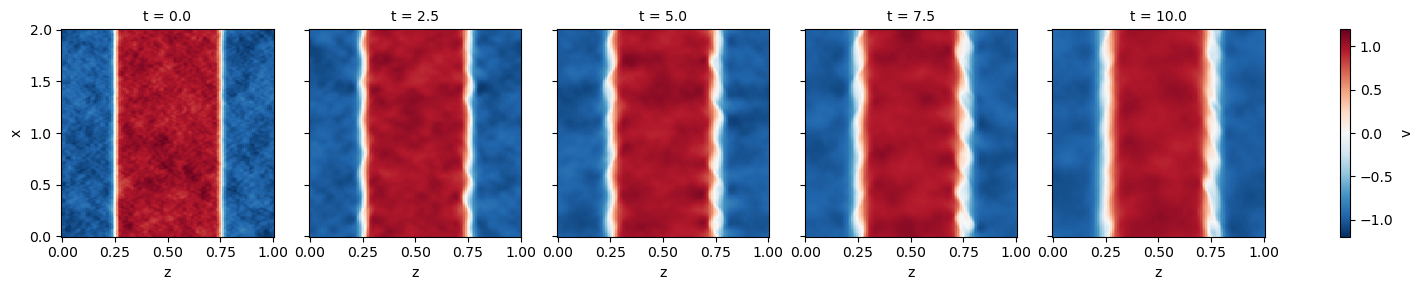

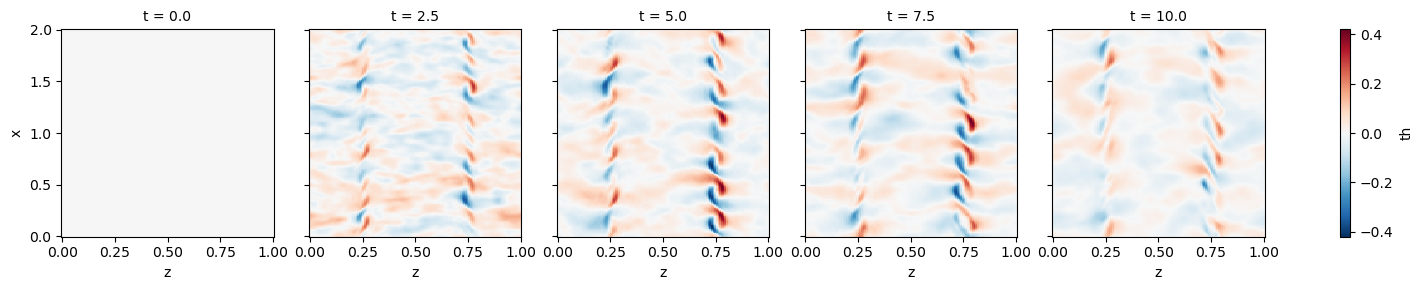

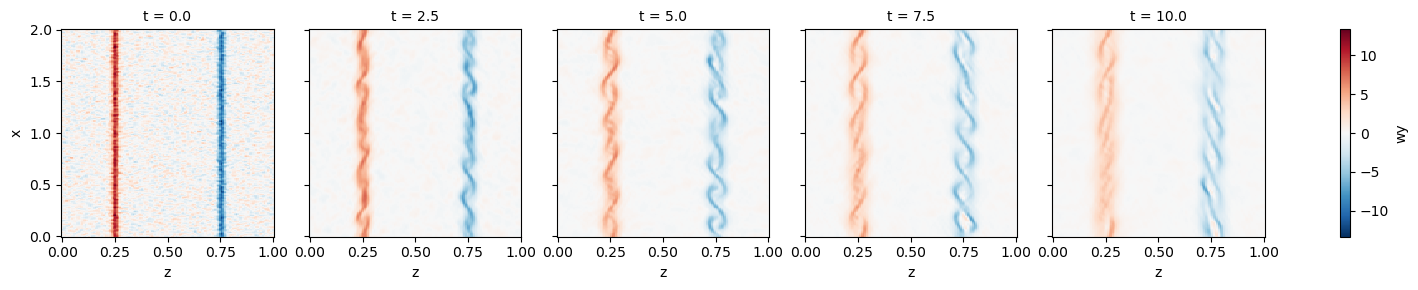

In [10]:
corte = data.isel(y=8, t=slice(0, None, 5))
corte.v.sel(i="x").plot(col="t")
corte.th.plot(col="t")
corte.wy.plot(col="t")

Para las 3 variables,
se observa que se produce una inestabilidad
en las regiones donde hay un gradiente de velocidad.
Esta parece crecer espacialmente
a medida que evoluciona el tiempo.

Es importante que haya perturbaciones en el campo de velocidad
para que se produzca la inestabilidad.
Si apagamos la perturbación
($u_1 = 0$ en los parámetros del solver),
el gradiente se suaviza por difusión,
pero no se desarrolla la inestabilidad,
que requiere romper la simetría:

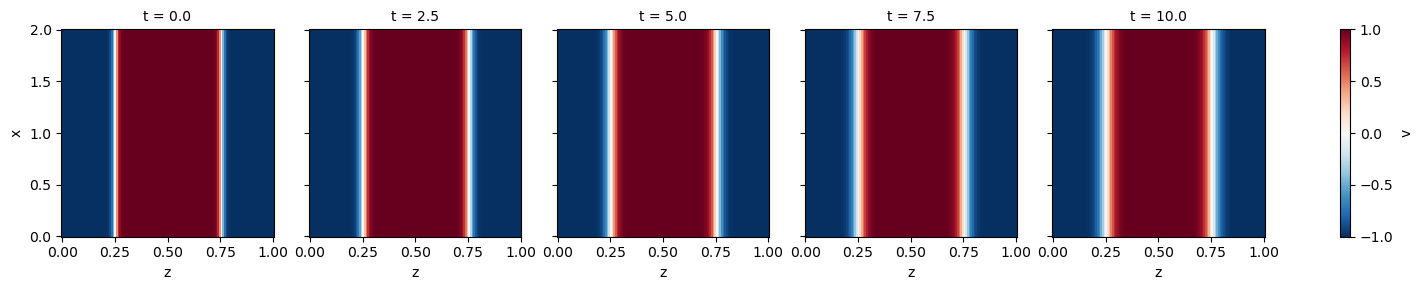

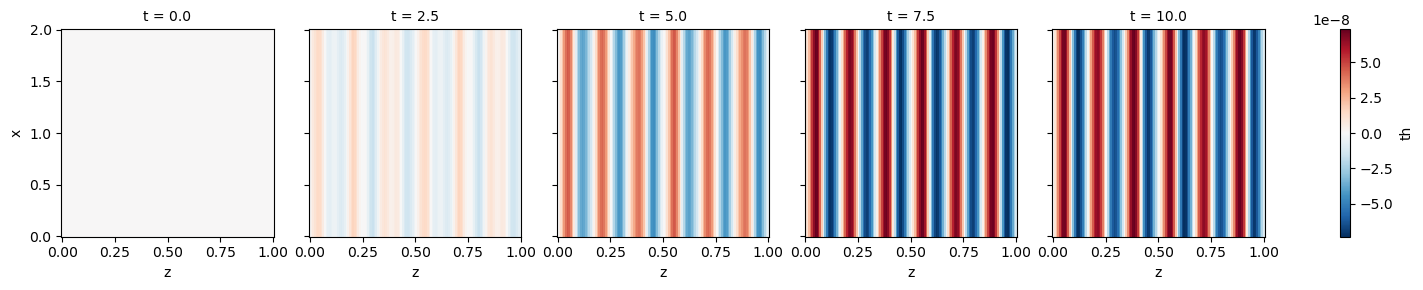

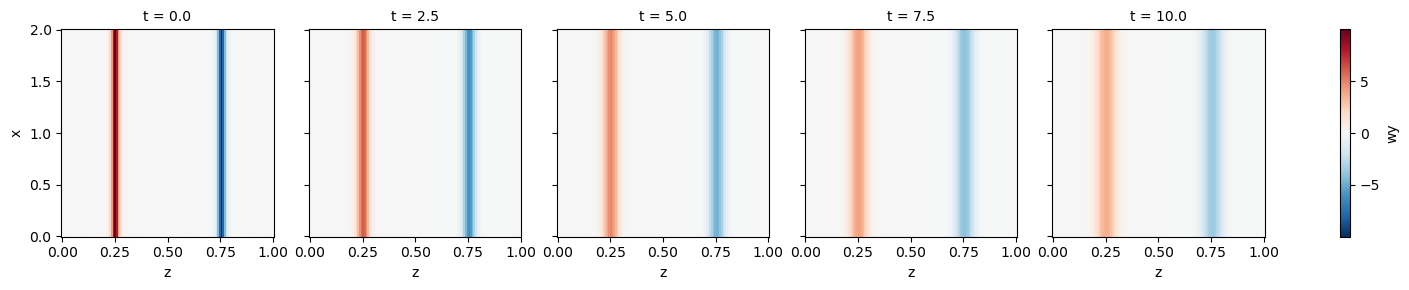

In [11]:
data = open_simulation("random0")
corte = data.isel(y=8, t=slice(0, None, 5))
corte.v.sel(i="x").plot(col="t")
corte.th.plot(col="t")
corte.wy.plot(col="t")

### d)
> Con los mismos parámetros del punto c),
realice ahora simulaciones variando $N$ entre $0$ y $6$ (pasos de a $1$).
¿Qué ocurre?
Estime la tasa de crecimiento de la inestabilidad
en función del máximo número de Richardson en el flujo.

In [12]:
def open_many(name, variable):
    files = path.glob(f"{name}*")
    files = [(file.stem.removeprefix(name), file) for file in files]
    files = sorted(files, key=lambda x: float(x[0]))
    return xarray.merge(open_dataarray(
        file,
        variable,
        dt=dt_save,
        shape=coords,
        dtype=np.float32,
    ).rename(name) for name, file in files)

In [13]:
data_N = open_many("N", "vx")
data_N

<xarray.Dataset>
Dimensions:  (x: 256, y: 16, z: 128, t: 21)
Coordinates:
  * x        (x) float64 0.0 0.007843 0.01569 0.02353 ... 1.976 1.984 1.992 2.0
  * y        (y) float64 0.0 0.06667 0.1333 0.2 0.2667 ... 0.8 0.8667 0.9333 1.0
  * z        (z) float64 0.0 0.007874 0.01575 0.02362 ... 0.9843 0.9921 1.0
  * t        (t) float64 0.0 0.5 1.0 1.5 2.0 2.5 ... 7.5 8.0 8.5 9.0 9.5 10.0
Data variables:
    0        (t, x, y, z) float32 dask.array<chunksize=(1, 256, 16, 128), meta=np.ndarray>
    1        (t, x, y, z) float32 dask.array<chunksize=(1, 256, 16, 128), meta=np.ndarray>
    2        (t, x, y, z) float32 dask.array<chunksize=(1, 256, 16, 128), meta=np.ndarray>
    3        (t, x, y, z) float32 dask.array<chunksize=(1, 256, 16, 128), meta=np.ndarray>
    4        (t, x, y, z) float32 dask.array<chunksize=(1, 256, 16, 128), meta=np.ndarray>
    5        (t, x, y, z) float32 dask.array<chunksize=(1, 256, 16, 128), meta=np.ndarray>
    6        (t, x, y, z) float32 dask.array<chunksize=(1, 256, 16, 128), meta=np.ndarray>

A medida que crece el número de Brunt-Väisälä $N$,
el efecto restaurativo de la gravedad en el flujo estratificado es mayor,
y las perturbaciones en la interfaz no generan un mezclado del fluido.

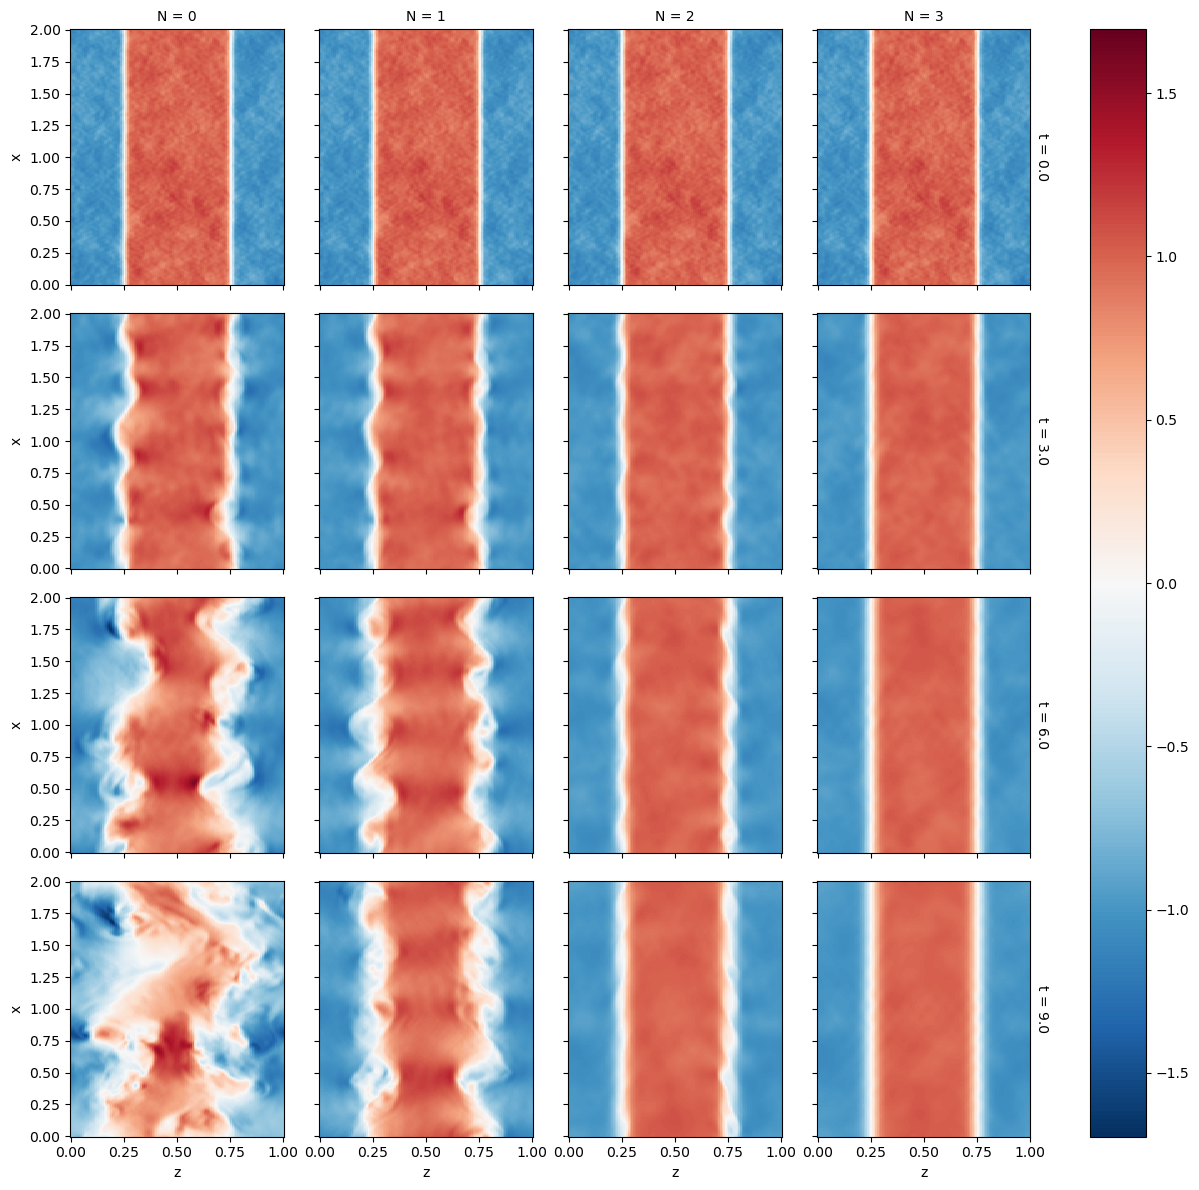

In [14]:
data_N.to_array("N").isel(y=8, t=slice(0, None, 6), N=slice(0, 4)).plot(col="N", row="t")

En particular,
para $\gamma = 2$,
el número de Richardson es mayor al número crítico de $1/4$
cuando $N > 5$,
y el sistema se vuelve estable.

[Text(0.5, 0, 'Frecuencia de Brunt-Väisälä N'),
 Text(0, 0.5, 'Número de Richardson'),
 Text(0.5, 1.0, '$\\gamma = 2$')]

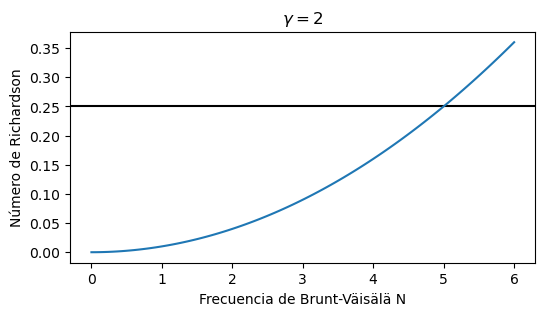

In [15]:
fig, ax = plt.subplots(figsize=(6, 3), dpi=100)
ax.axhline(1/4, color="black")

N = np.linspace(0, 6, 100)
ax.plot(N, richardson(N=N, gamma=10))
ax.set(
    xlabel="Frecuencia de Brunt-Väisälä N",
    ylabel="Número de Richardson",
    title="$\gamma = 2$",
)

Para ver la tasa de crecimiento de la inestabilidad,
vamos a tomar un corte alrededor de una de las inestabilidades:

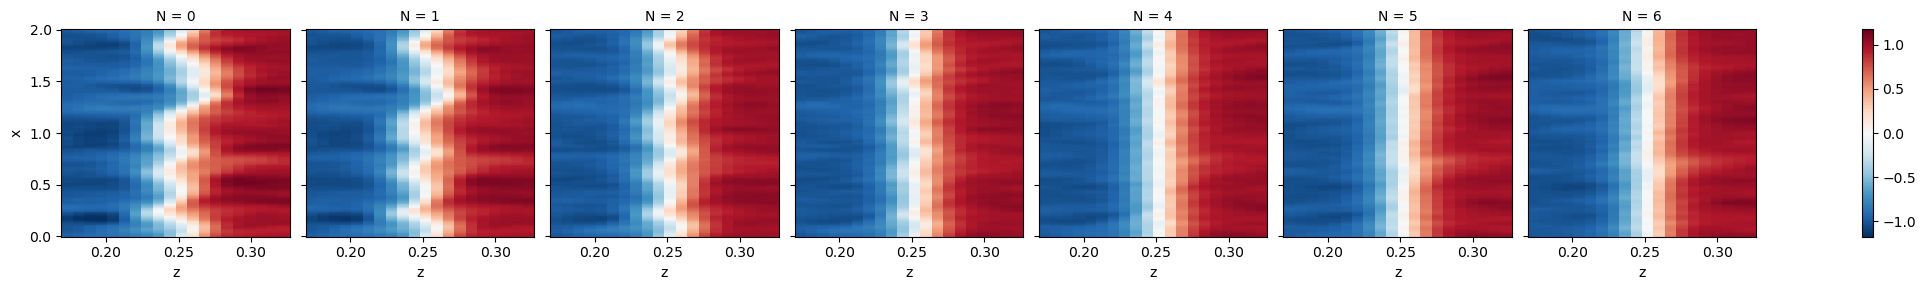

In [16]:
corte = data_N.to_array("N").isel(z=slice(22, 42))

corte.isel(y=8, t=3).plot(col="N")

Tomando como métrica para la inestabilidad
a la desviación estándar de la componente $x$ de la velocidad,
obtenemos los siguientes perfiles en función del tiempo:

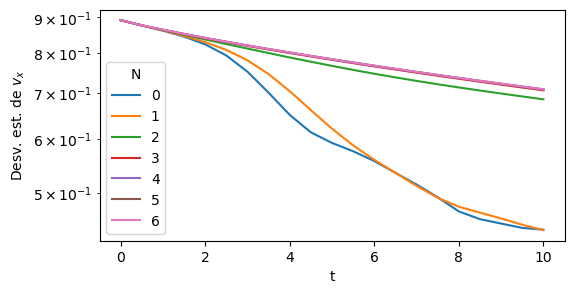

In [17]:
inestabilidad = corte.std(["x", "y", "z"])

inestabilidad.plot.line(x="t")
plt.ylabel("Desv. est. de $v_x$")
plt.yscale("log")

Al inicio,
para $t < 2$,
el desarrollo de la inestabilidad se produce variaciones de la velocidad
que evolucionan de manera exponencial.
Ajustando dicha tasa de decaimiento en función de $N$,
obtenemos que esta se estabiliza para $N \sim 5$,
que es cuando el número de Richardson cruza el valor crítico de $1/4$.

Text(0.5, 1.0, '$t < 2$')

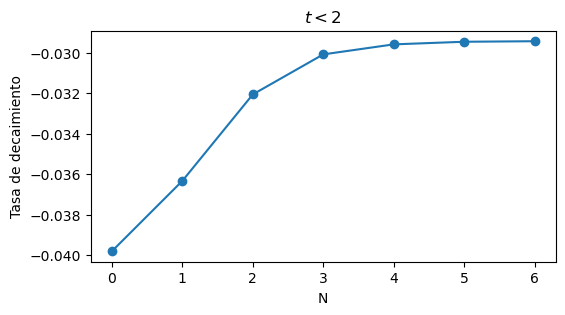

In [18]:
def slope(x):
    return np.log(x).polyfit("t", 1).sel(degree=1)


slopes = inestabilidad.sel(t=slice(0, 2)).groupby("N").map(slope)["polyfit_coefficients"]
slopes.assign_coords(N=slopes.N.astype(int)).plot(marker="o")
plt.ylabel("Tasa de decaimiento")
plt.title("$t < 2$")

### e)
> Con los mismos parámetros del punto c),
fije ahora $N = 2$
y varíe $γ$ entre $5$ y $20$ (pasos de a $5$).
Grafique el número de onda del modo más inestable
en función de $γ$
(ayuda: puede estimar este número de onda
contando cuantos máximos de la vorticidad $ω_y$ aparecen a lo largo de un corte horizontal
a medida que se desarrolla la inestabilidad)

In [19]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import sympy
import xarray
from ghost_xarray import open_dataarray, open_dataset

plt.rc("figure", dpi=100, figsize=(6, 3))
path = Path("problema3/output")
L = np.array([2, 1, 1])
N = np.array([256, 16, 128])

2 * np.pi * L / N
dt_CFL = 0.05
dt_solver = dt_CFL / 10

t_total = 10
N_steps = t_total / dt_solver

dt_save = 0.5
N_step_save = dt_save / dt_solver

print("             Paso Δt:", dt_solver)
print("             N pasos:", N_steps)
print("Guardar cada N pasos:", N_step_save)
coords = {i: np.linspace(0, Li, Ni) for i, Li, Ni in zip("xyz", L, N)}


def open_simulation(name, var_names=["v", "wy", "th"]):
    return open_dataset(
        path / name,
        var_names,
        dt=dt_save,
        shape=coords,
        dtype=np.float32,
    )

def open_many(name, variable):
    files = path.glob(f"{name}*")
    files = [(file.stem.removeprefix(name), file) for file in files]
    files = sorted(files, key=lambda x: float(x[0]))
    return xarray.merge(open_dataarray(
        file,
        variable,
        dt=dt_save,
        shape=coords,
        dtype=np.float32,
    ).rename(name) for name, file in files)

             Paso Δt: 0.005
             N pasos: 2000.0
Guardar cada N pasos: 100.0


In [20]:
data_gamma = open_many("gamma", "wy")
data_gamma

<xarray.Dataset>
Dimensions:  (x: 256, y: 16, z: 128, t: 21)
Coordinates:
  * x        (x) float64 0.0 0.007843 0.01569 0.02353 ... 1.976 1.984 1.992 2.0
  * y        (y) float64 0.0 0.06667 0.1333 0.2 0.2667 ... 0.8 0.8667 0.9333 1.0
  * z        (z) float64 0.0 0.007874 0.01575 0.02362 ... 0.9843 0.9921 1.0
  * t        (t) float64 0.0 0.5 1.0 1.5 2.0 2.5 ... 7.5 8.0 8.5 9.0 9.5 10.0
Data variables:
    5        (t, x, y, z) float32 dask.array<chunksize=(1, 256, 16, 128), meta=np.ndarray>
    10       (t, x, y, z) float32 dask.array<chunksize=(1, 256, 16, 128), meta=np.ndarray>
    15       (t, x, y, z) float32 dask.array<chunksize=(1, 256, 16, 128), meta=np.ndarray>
    20       (t, x, y, z) float32 dask.array<chunksize=(1, 256, 16, 128), meta=np.ndarray>

Si graficamos $\omega_y$
en función del tiempo (filas)
y de $\gamma$ (columnas),
vemos que la inestabilidad crece más rapidamente
cuando el gradiente de valocidad ($\gamma$) es mayor.

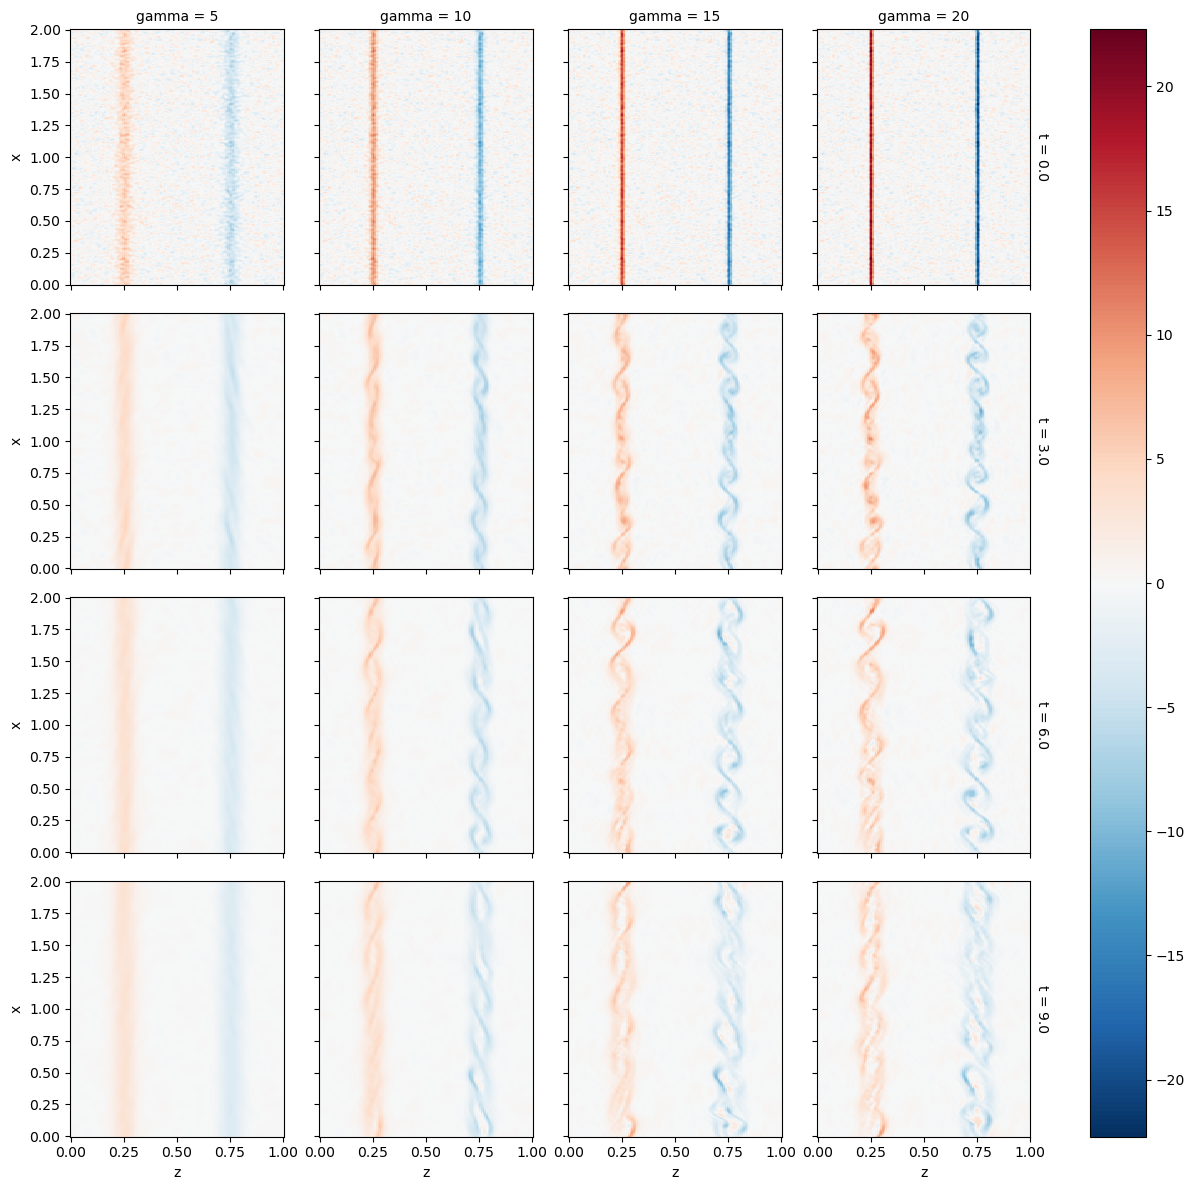

In [21]:
data_gamma.isel(y=8).sel(t=slice(0, None, 6)).to_array("gamma").plot(col="gamma", row="t")

In [22]:
def normalize(x):
    vmin, vmax = np.percentile(x, (2, 98))
    return (x - vmin) / (vmax - vmin)

Hacemos un zoom en una de las zonas de inestabilidad, graficando:

In [23]:
inestabilidad = data_gamma.isel(z=slice(32, 40), t=10)

- para un $y$ fijo:

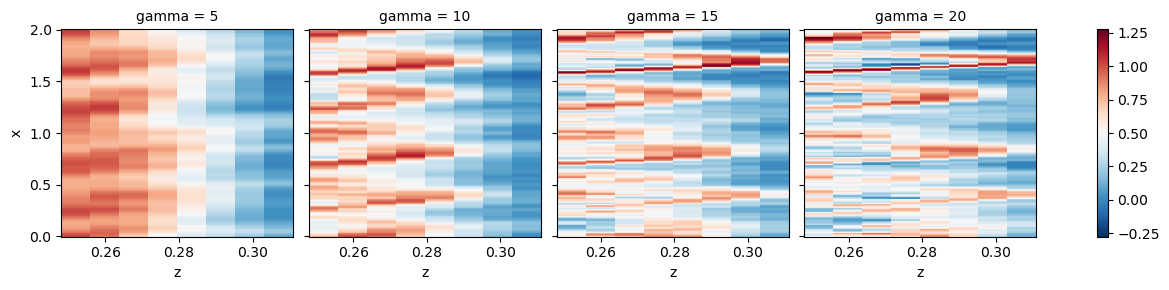

In [24]:
inestabilidad.isel(y=8).map(normalize).to_array("gamma").plot(col="gamma", center=0.5)

- para un $z$ fijo:

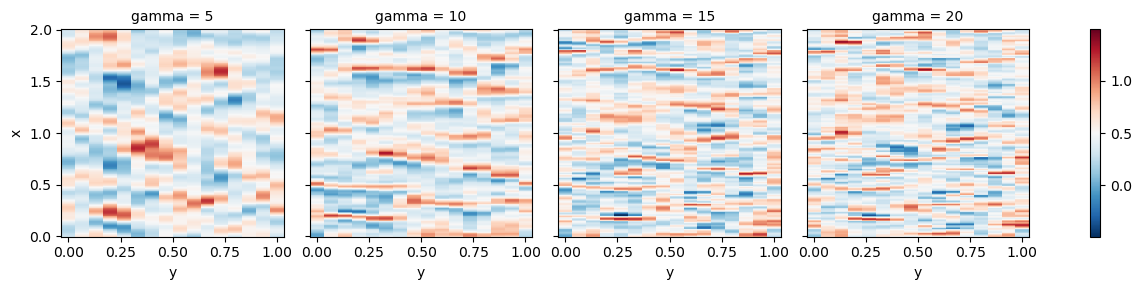

In [25]:
inestabilidad.sel(z=0.27, method="nearest").map(normalize).to_array("gamma").plot(col="gamma", center=0.5)

- un perfil para $y$ y $z$ fijos:

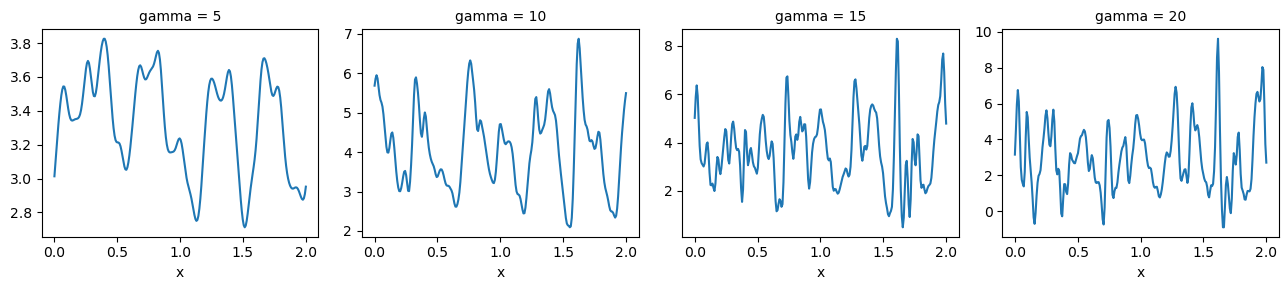

In [26]:
perfil = inestabilidad.isel(y=8).sel(z=0.27, method="nearest").compute()

perfil.to_array("gamma").plot(col="gamma", sharey=False)

En la vorticidad,
se ven estructuras cuya longitud de onda disminuye
a medida que crece $\gamma$.

Para calcular la longitud del modo predominante,
vamos a realizar la transfomada de Fourier a estos perfiles:

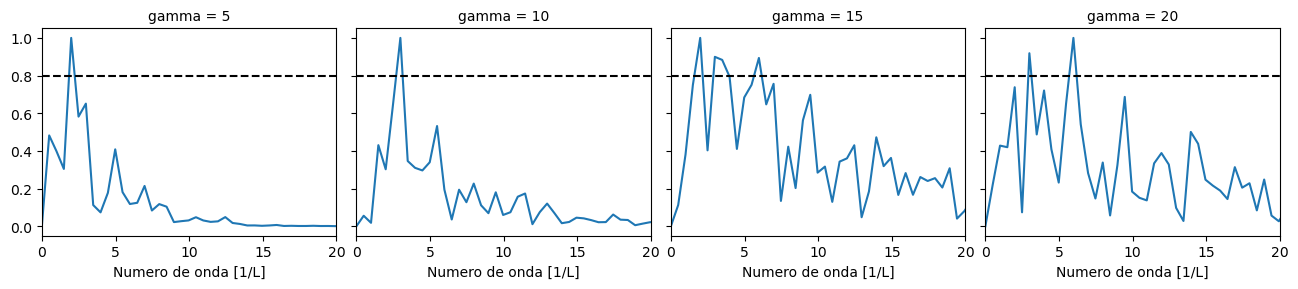

In [27]:
def abs_rfft(x):
    x = x - x.mean()
    k = np.abs(np.fft.rfft(x))
    k = k / k.max()
    dx = x.x.diff("x").values.mean()
    freq = np.fft.rfftfreq(x.size, d=dx)
    return xarray.DataArray(k, coords={"numero_de_onda": freq})


espectro = perfil.map(abs_rfft)
axes = espectro.to_array("gamma").plot.line(x="numero_de_onda", col="gamma")
for ax in axes.axes.flat:
    ax.axhline(0.8, color="black", linestyle="--")
    ax.set(xlabel="Numero de onda [1/L]", xlim=(0, 20))

Para los modos que superan ese umbral (arbitrario),
graficamos el número de modo en función de $\gamma$:

Text(0, 0.5, 'Número de onda')

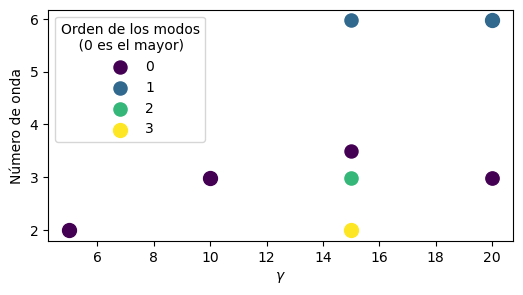

In [28]:
k = espectro.to_pandas()
max_k = k[k > 0.8]

N = max_k.count().max()
colors = plt.get_cmap("viridis")(np.linspace(0, 1, N))

for gamma, k in max_k.items():
    k = k.dropna().sort_values()
    for i, (ki, size) in enumerate(k.items()):
        label = i if len(k) == N else "_"
        plt.scatter(float(gamma), ki, s=size * 100, color=colors[i], label=label)
plt.legend(title="Orden de los modos\n    (0 es el mayor)")
plt.xlabel("$\gamma$")
plt.ylabel("Número de onda")